In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [300]:
data = pd.read_csv("LoanApprovalPrediction.csv")

In [301]:
# Dropping Loan_ID column because it isn't useful for prediction
data.drop(['Loan_ID'], axis=1, inplace=True)
# Check for missing values
data.isna().sum()
data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [302]:
############### PREPROCESSING ##################
######### IMPUTING MISSING VALUES #########

# Categorical Value Fill NA with Mode
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)

# Numerical Value Fill NA with Mean
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)   

data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [303]:
from sklearn import preprocessing

## Converting categorical values to numerical values
label_encoder = preprocessing.LabelEncoder()

# Convert all non-numeric values to number
obj = (data.dtypes == 'object')
for col in list(obj[obj].index):
    data[col] = label_encoder.fit_transform(data[col])
    
data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0.0,0,0,5849,0.0,144.968804,360.0,1.0,2,1
1,1,1,1.0,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0.0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,0.0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0.0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


In [304]:
######### NORMALIZATION #########
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
data = pd.DataFrame(data_normalized, columns=data.columns)

data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.000000,0.0,0.0,0.070489,0.000000,0.212120,0.74359,1.0,1.0,1.0
1,1.0,1.0,0.333333,0.0,0.0,0.054830,0.036192,0.185647,0.74359,1.0,0.0,0.0
2,1.0,1.0,0.000000,0.0,1.0,0.035250,0.000000,0.088924,0.74359,1.0,1.0,1.0
3,1.0,1.0,0.000000,1.0,0.0,0.030093,0.056592,0.173167,0.74359,1.0,1.0,1.0
4,1.0,0.0,0.000000,0.0,0.0,0.072356,0.000000,0.205928,0.74359,1.0,1.0,1.0


In [305]:
######### OUTLIER DETECTION #########
from scipy import stats

# Check for outliers using Z-score
z_scores = pd.DataFrame()
for col in data.columns:
    z_scores[col] = stats.zscore(data[col])

# Define a threshold for considering values as outliers
threshold = 3.5

# Identify outliers
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Remove the outliers from the dataset
data = data[~outliers.any(axis=1)]

# Display the count of outliers in each numerical column
outliers_count = outliers.sum()

print("Outliers Count:")
print(outliers_count)

Outliers Count:
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       6
CoapplicantIncome     4
LoanAmount           12
Loan_Amount_Term      9
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64


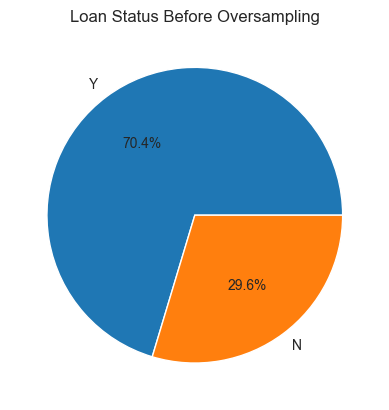

Class distribution before oversampling in the training set: Counter({1.0: 280, 0.0: 118})


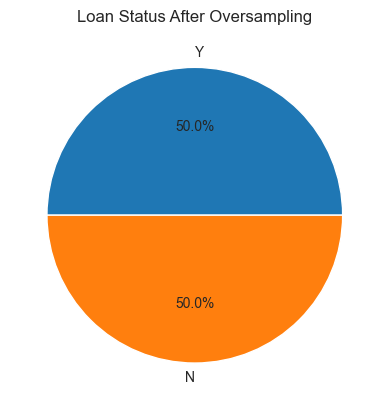

Class distribution after oversampling in the training set: Counter({1.0: 280, 0.0: 280})


In [306]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

##### RESAMPLING

# Remove the target column from the dataset
X = data.drop(['Loan_Status'], axis=1)

# Copy the target column to a new variable
Y = data['Loan_Status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=11)

temp_before = Counter(Y_train)
plt.pie(temp_before.values(), labels=['Y', 'N'], autopct='%1.1f%%')
plt.title('Loan Status Before Oversampling')
plt.show()

print("Class distribution before oversampling in the training set:", Counter(Y_train))

# Apply SMOTE to OVERSAMPLE the minority class in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train, Y_train = smote.fit_resample(X_train, Y_train)

# Display the class distribution after oversampling in the training set
temp_after = Counter(Y_train)
plt.pie(temp_after.values(), labels=['Y', 'N'], autopct='%1.1f%%')
plt.title('Loan Status After Oversampling')
plt.show()

print("Class distribution after oversampling in the training set:", Counter(Y_train))

<Axes: >

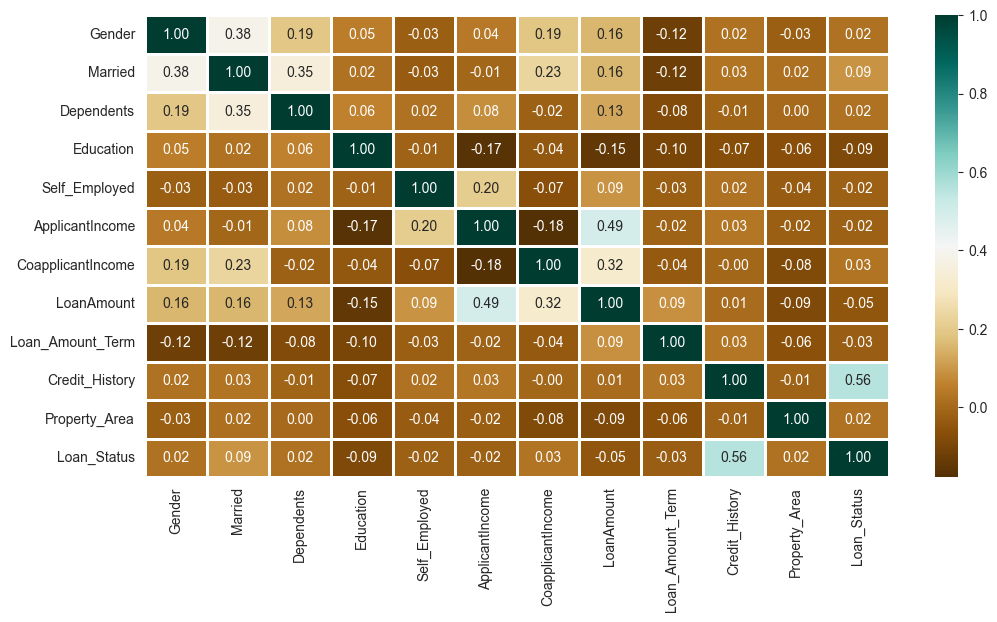

In [307]:
plt.figure(figsize=(12, 6))

sns.heatmap(data.corr(), cmap='BrBG', fmt='.2f',
            linewidths=2, annot=True)

In [308]:
############### Modelling ##################

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [309]:
#### Create a list of classifiers
classifiers = [
    ("Random Forest", RandomForestClassifier(n_estimators=7, criterion='entropy')),
    ("kNN", KNeighborsClassifier(n_neighbors=5)),
    ("SVM", SVC(kernel='linear')),
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier())
]

In [310]:
#### Train each classifier
for clf_name, clf in classifiers:
    clf.fit(X_train, Y_train)

Testing on 171 samples...
Classifier: Random Forest

Accuracy: 0.766
Precision: 0.803
Recall: 0.860
F1 : 0.831


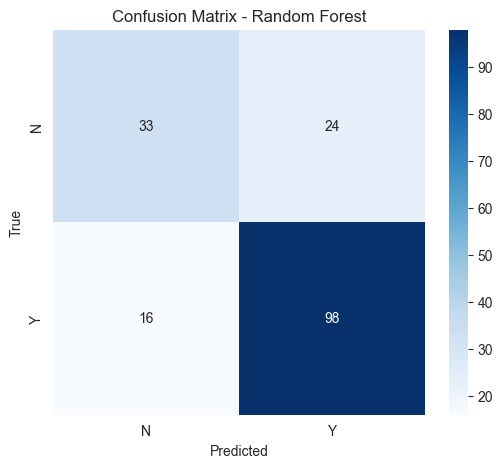

Testing on 171 samples...
Classifier: kNN

Accuracy: 0.673
Precision: 0.784
Recall: 0.702
F1 : 0.741


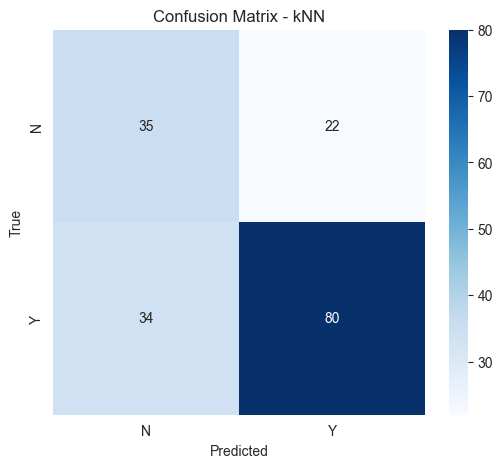

Testing on 171 samples...
Classifier: SVM

Accuracy: 0.825
Precision: 0.800
Recall: 0.982
F1 : 0.882


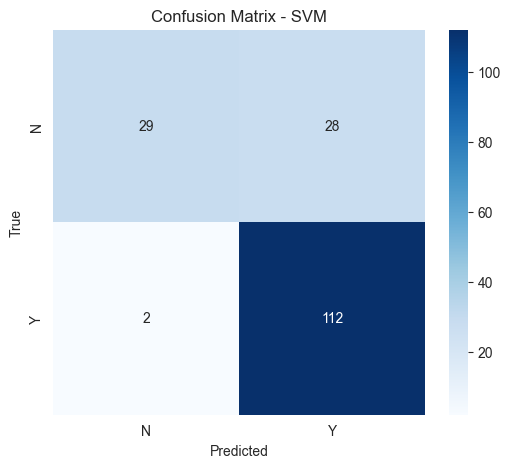

Testing on 171 samples...
Classifier: Naive Bayes

Accuracy: 0.825
Precision: 0.800
Recall: 0.982
F1 : 0.882


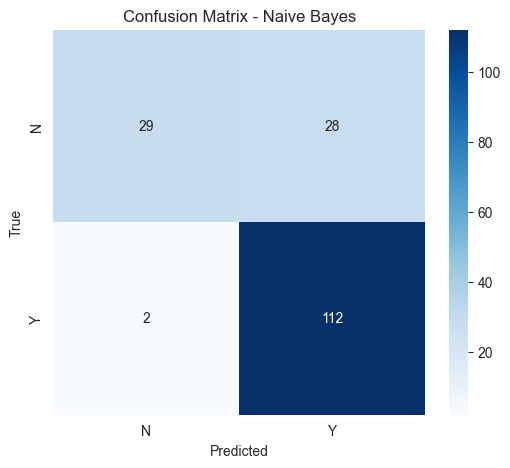

Testing on 171 samples...
Classifier: Logistic Regression

Accuracy: 0.789
Precision: 0.805
Recall: 0.904
F1 : 0.851


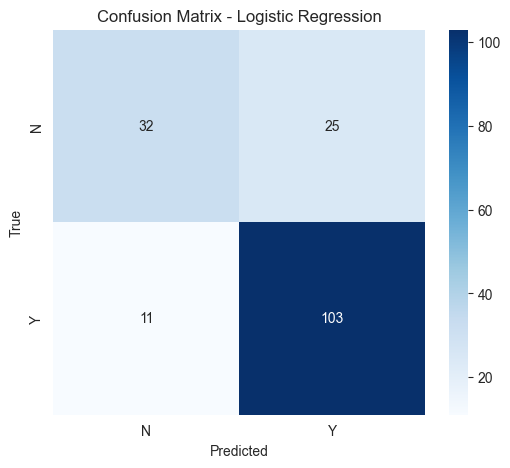

Testing on 171 samples...
Classifier: Decision Tree

Accuracy: 0.731
Precision: 0.804
Recall: 0.789
F1 : 0.796


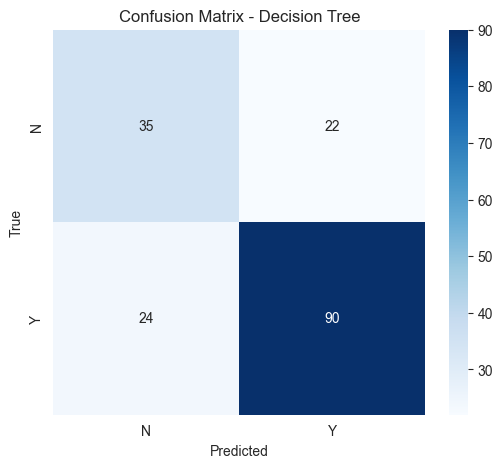

In [311]:
#### Test each classifier

classifier_names = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

for clf_name, clf in classifiers:
    Y_pred = clf.predict(X_test)
    
    # Calculate accuracy, precision, recall, and specificity
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    precision = metrics.precision_score(Y_test, Y_pred)
    recall = metrics.recall_score(Y_test, Y_pred)
    f1 = metrics.f1_score(Y_test, Y_pred)
    
    classifier_names.append(clf_name)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)
    
    print("Testing on {} samples...".format(len(X_test)))
    print(f"Classifier: {clf_name}\n")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 : {f1:.3f}\n")
    
    # Create a confusion matrix
    conf_matrix = metrics.confusion_matrix(Y_test, Y_pred)

    #Display the confusion matrix 
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['N', 'Y'],
                 yticklabels=['N', 'Y'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {clf_name}')
    plt.show()

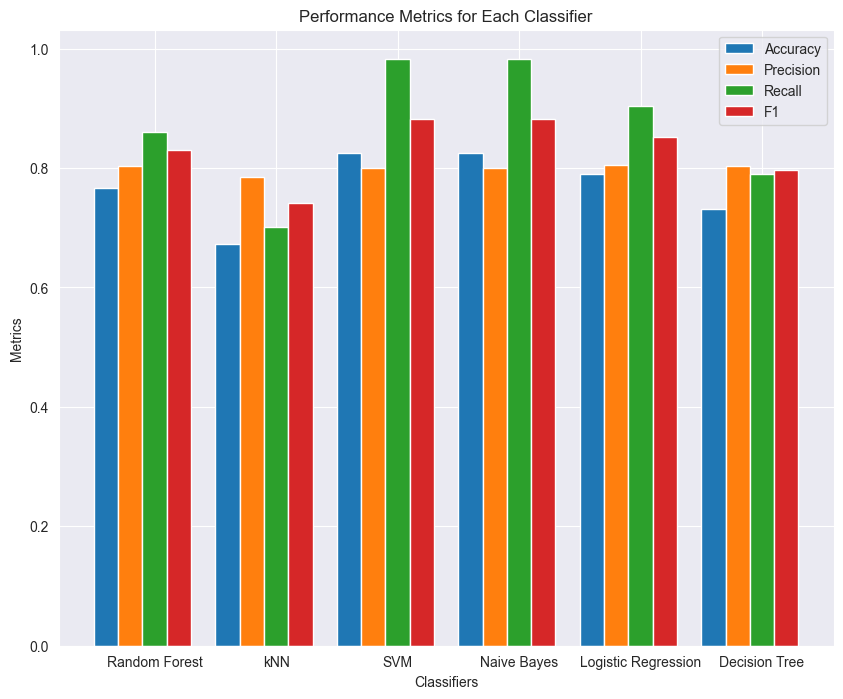

In [312]:
import numpy as np

bar_width = 0.2
index = np.arange(len(classifier_names))
fig, ax = plt.subplots(figsize=(10, 8))

rects1 = ax.bar(index - bar_width, accuracy_values, bar_width, label='Accuracy')
rects2 = ax.bar(index, precision_values, bar_width, label='Precision')
rects3 = ax.bar(index + bar_width, recall_values, bar_width, label='Recall')
rects4 = ax.bar(index + 2 * bar_width, f1_values, bar_width, label='F1')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Metrics')
ax.set_title('Performance Metrics for Each Classifier')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classifier_names)
ax.legend()

plt.show()

In [313]:
########## K FOLD ########

X = data.drop(['Loan_Status'], axis=1)
Y = data['Loan_Status']

# Apply SMOTE to oversample the minority class in the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)

X, Y = smote.fit_resample(X, Y)

Classifier: Random Forest
Accuracy: 0.788
Precision: 0.775
Recall: 0.812
F1 Score: 0.793


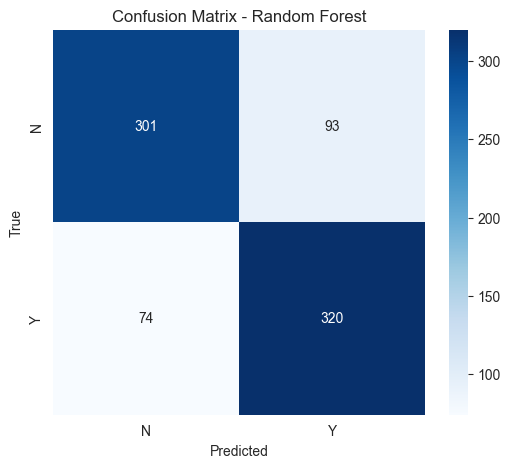

Classifier: kNN
Accuracy: 0.756
Precision: 0.749
Recall: 0.772
F1 Score: 0.760


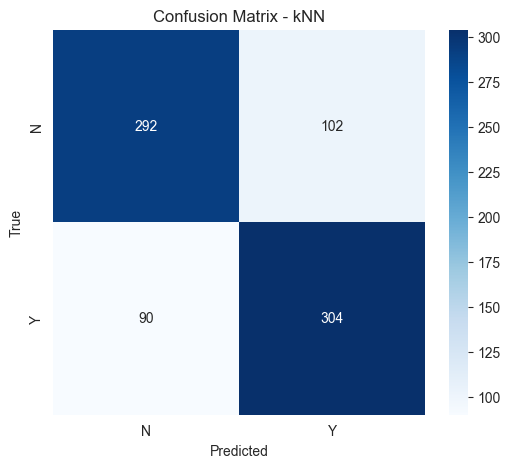

Classifier: SVM
Accuracy: 0.721
Precision: 0.645
Recall: 0.985
F1 Score: 0.779


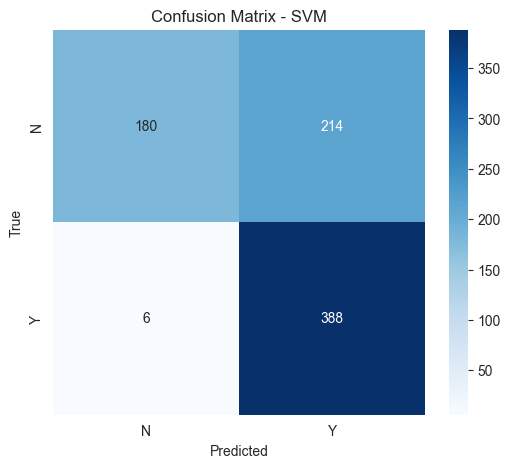

Classifier: Naive Bayes
Accuracy: 0.722
Precision: 0.646
Recall: 0.985
F1 Score: 0.780


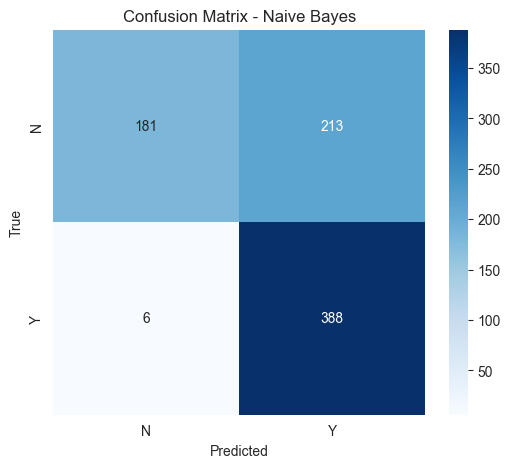

Classifier: Logistic Regression
Accuracy: 0.721
Precision: 0.649
Recall: 0.962
F1 Score: 0.775


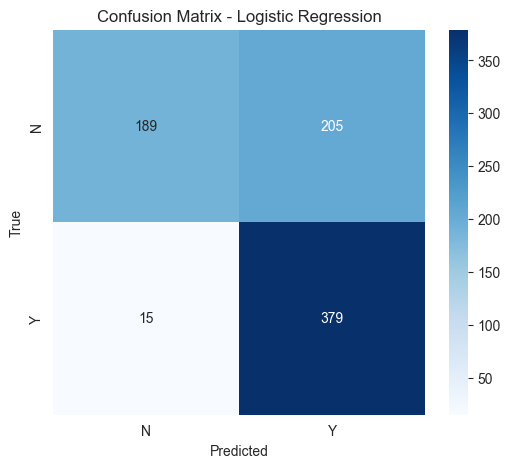

Classifier: Decision Tree
Accuracy: 0.742
Precision: 0.736
Recall: 0.756
F1 Score: 0.746


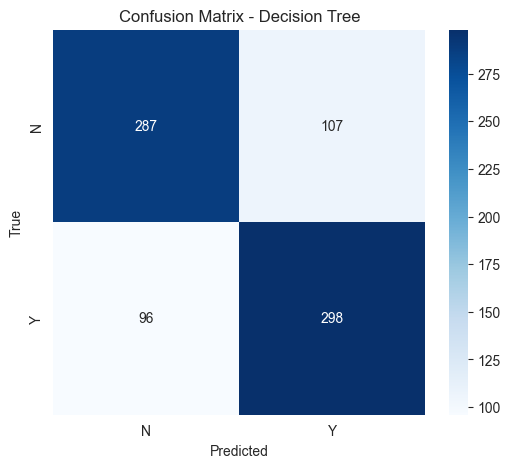

In [314]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold

classifier_names = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Use StratifiedKFold to maintain class distribution during cross-validation
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

# Perform k-fold cross-validation for each classifier
for clf_name, clf in classifiers:
    print(f"Classifier: {clf_name}")

    # Perform k-fold cross-validation
    Y_pred = cross_val_predict(clf, X, Y, cv=k_fold)

    # Calculate and print metrics
    accuracy = metrics.accuracy_score(Y, Y_pred)
    precision = metrics.precision_score(Y, Y_pred)
    recall = metrics.recall_score(Y, Y_pred)
    f1_score = metrics.f1_score(Y, Y_pred)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1_score:.3f}\n")
    
    classifier_names.append(clf_name)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1_score)
    
    #Create a confusion matrix
    conf_matrix = metrics.confusion_matrix(Y, Y_pred)

    # Display the confusion matrix 
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['N', 'Y'],
                yticklabels=['N', 'Y'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {clf_name}')
    plt.show()

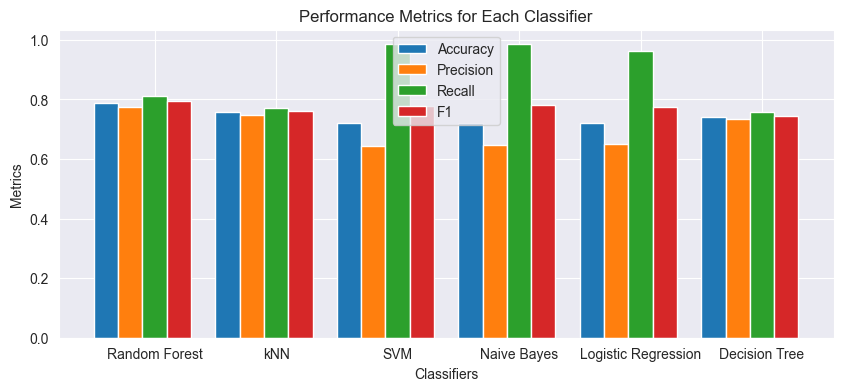

In [315]:
import numpy as np

# Plot the metrics using a bar chart
bar_width = 0.2
index = np.arange(len(classifier_names))
fig, ax = plt.subplots(figsize=(10, 4))

rects1 = ax.bar(index - bar_width, accuracy_values, bar_width, label='Accuracy')
rects2 = ax.bar(index, precision_values, bar_width, label='Precision')
rects3 = ax.bar(index + bar_width, recall_values, bar_width, label='Recall')
rects4 = ax.bar(index + 2 * bar_width, f1_values, bar_width, label='F1')

# Add labels, title, and legend
ax.set_xlabel('Classifiers')
ax.set_ylabel('Metrics')
ax.set_title('Performance Metrics for Each Classifier')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classifier_names)
ax.legend()

# Display the bar chart
plt.show()